# Learnable loss

## Import librarys and model

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

## Generate data

In [2]:
training_sample_count = 300
x_train = torch.rand((training_sample_count,2), dtype=torch.float32)*4.0-2.0
x_train[:,1] = np.sin(5.0*x_train[:,0])
x_train[training_sample_count//2:,1] += (0.5+torch.rand(training_sample_count//2)) - (np.random.randn(training_sample_count//2)<0)*2.0
y_train = torch.ones((x_train.shape[0]), dtype=torch.long)
y_train[training_sample_count//2:] = 0

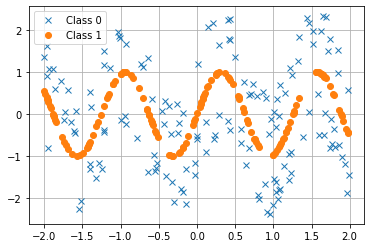

In [3]:
plt.plot(x_train[training_sample_count//2:,0],x_train[training_sample_count//2:,1], 'x', label='Class 0')
plt.plot(x_train[:training_sample_count//2,0],x_train[:training_sample_count//2,1], 'o', label='Class 1')
plt.legend()
plt.grid()
plt.show()

In [10]:
validation_sample_count = 100
x_val = torch.rand((validation_sample_count,2), dtype=torch.float32)*4.0-2.0
x_val[:,1] = np.sin(5.0*x_val[:,0])
x_val[validation_sample_count//2:,1] += (0.5+torch.rand(validation_sample_count//2)) - (np.random.randn(validation_sample_count//2)<0)*2.0
y_val = torch.ones((x_val.shape[0]), dtype=torch.long)
y_val[validation_sample_count//2:] = 0

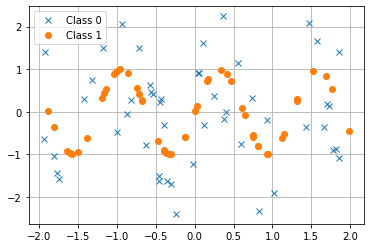

In [11]:
plt.plot(x_val[validation_sample_count//2:,0],x_val[validation_sample_count//2:,1], 'x', label='Class 0')
plt.plot(x_val[:validation_sample_count//2,0],x_val[:validation_sample_count//2,1], 'o', label='Class 1')
plt.legend()
plt.grid()
plt.show()

## Define model

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        count_hidden = 100
        self.layers = nn.Sequential(
            nn.Linear(2, count_hidden),
            nn.ReLU(),
            nn.Linear(count_hidden, count_hidden),
            nn.ReLU(),
            nn.Linear(count_hidden, 2)
        )

    def forward(self, x):
        return self.layers(x)

## Standard loss

### Train model

In [13]:
model = Net()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

for epoch in range(20001):
    if epoch%1000 == 0:
        print(f"Epoch {epoch}:")

    model.train()
    z_train = model(x_train)
    loss = loss_function(z_train, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%1000 == 0:
        print(f"\tTraining loss: {loss.item()}")

    model.eval()
    z_val = model(x_val)
    loss = loss_function(z_val, y_val)
    if epoch%1000 == 0:
        print(f"\tvalidation loss: {loss.item()}\n")

Epoch 0:
	Training loss: 0.6949891448020935
	validation loss: 0.698081374168396

Epoch 1000:
	Training loss: 0.5835570693016052
	validation loss: 0.637571394443512

Epoch 2000:
	Training loss: 0.5466887950897217
	validation loss: 0.6167275905609131

Epoch 3000:
	Training loss: 0.5222426056861877
	validation loss: 0.5985224843025208

Epoch 4000:
	Training loss: 0.4986552894115448
	validation loss: 0.5789933800697327

Epoch 5000:
	Training loss: 0.47558537125587463
	validation loss: 0.5611746311187744

Epoch 6000:
	Training loss: 0.4539342224597931
	validation loss: 0.5462777614593506

Epoch 7000:
	Training loss: 0.43363046646118164
	validation loss: 0.5324441194534302

Epoch 8000:
	Training loss: 0.41519632935523987
	validation loss: 0.5218459963798523

Epoch 9000:
	Training loss: 0.3989006578922272
	validation loss: 0.5145913362503052

Epoch 10000:
	Training loss: 0.38413265347480774
	validation loss: 0.5103322863578796

Epoch 11000:
	Training loss: 0.37047407031059265
	validation loss

### Evaluate model

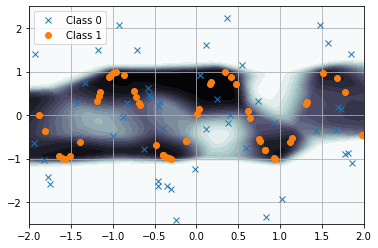

In [14]:
model.eval()
with torch.no_grad():
    resolution = 100
    grid_x, grid_y = torch.meshgrid(torch.linspace(-2.0, 2.0, resolution), torch.linspace(-2.5, 2.5, resolution))
    grid = torch.cat((torch.reshape(grid_x, (-1,1)), torch.reshape(grid_y, (-1,1))), 1)

    probs = nn.functional.softmax(model(grid), dim=1)
    output = torch.reshape(probs[:,0], (resolution,resolution))

    plt.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    plt.plot(x_val[validation_sample_count//2:,0],x_val[validation_sample_count//2:,1], 'x', label='Class 0')
    plt.plot(x_val[:validation_sample_count//2,0],x_val[:validation_sample_count//2,1], 'o', label='Class 1')
    plt.legend()
    plt.grid()
    plt.show()

## Learnable loss

### Define parameterized loss function (e.g. label smoothing)

In [15]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.0):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = nn.Parameter(smoothing.clone().detach())

    def forward(self, prediction, target):
        #assert 0 <= self.smoothing < 1
        neglog_softmaxPrediction = -prediction.log_softmax(dim=1)
        weights = torch.ones_like(prediction)*self.smoothing/(prediction.shape[1]-1)
        smoothedLabels = torch.scatter(weights, 1, target.unsqueeze(1), torch.ones((prediction.shape[0],1))-self.smoothing)
        return torch.mean(torch.sum(smoothedLabels*neglog_softmaxPrediction, dim=1))

### Bilevel training

In [ ]:
ll_model = Net()
ll_loss_function = LabelSmoothingLoss(torch.rand(1)/2.0)
ll_model_optimizer = torch.optim.SGD(ll_model.parameters(), lr=1e-2)
ll_loss_optimizer = torch.optim.SGD(ll_loss_function.parameters(), lr=1e-2)

for epoch in range(20001):
    if epoch%1000 == 0:
        print(f"Epoch {epoch}:")

    ll_model.train()
    z_train = ll_model(x_train)
    loss = ll_loss_function(z_train, y_train)
    ll_model_optimizer.zero_grad()
    loss.backward()
    ll_model_optimizer.step()
    
    if epoch%1000 == 0:
        print(f"\tTraining loss: {loss.item()}")

    #ll_model.eval()
    z_val = ll_model(x_val)
    loss = ll_loss_function(z_val, y_val)

    ll_loss_optimizer.zero_grad()
    loss.backward()
    ll_loss_optimizer.step()
    with torch.no_grad():
        ll_loss_function.smoothing.copy_(torch.clamp(ll_loss_function.smoothing, 0, 1))

    if epoch%1000 == 0:
        print(f"\tvalidation loss: {loss.item()}")
        print(f"\tSmoothing value: {ll_loss_function.smoothing.item()}")
        print()

### Evaluate model

In [ ]:
ll_model.eval()
with torch.no_grad():
    resolution = 100
    grid_x, grid_y = torch.meshgrid(torch.linspace(-2.0, 2.0, resolution), torch.linspace(-2.5, 2.5, resolution))
    grid = torch.cat((torch.reshape(grid_x, (-1,1)), torch.reshape(grid_y, (-1,1))), 1)
    
    probs = nn.functional.softmax(ll_model(grid), dim=1)
    output = torch.reshape(probs[:,0], (resolution,resolution))

    plt.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    plt.plot(x_val[validation_sample_count//2:,0],x_val[validation_sample_count//2:,1], 'x', label='Class 0')
    plt.plot(x_val[:validation_sample_count//2,0],x_val[:validation_sample_count//2,1], 'o', label='Class 1')
    plt.legend()
    plt.grid()
    plt.show()